In [1]:
# load training result get from preprocess.py module
import json
with open('ad2Adv.json', 'r') as fp:
    ad2AdvStr = json.load(fp)

with open('ad2Cam.json', 'r') as fp:
    ad2CamStr = json.load(fp)

with open('finalDis2Doc.json', 'r') as fp:
    finalDis2DocStr = json.load(fp)
    
with open('finalDoc2Cate.json', 'r') as fp:
    finalDoc2CateStr = json.load(fp) 

with open('finalDoc2Topic.json', 'r') as fp:
    finalDoc2TopicStr = json.load(fp)  
    
with open('finalDoc2Meta.json', 'r') as fp:
    finalDoc2MetaStr = json.load(fp)  
    
with open('finalData.json', 'r') as fp:
    finalDataStr = json.load(fp) 

In [2]:
# convert str dict to value dict
ad2Adv = dict()
for each in ad2AdvStr:
    ad2Adv[float(each)] = float(ad2AdvStr[each])

ad2Cam = dict()
for each in ad2CamStr:
    ad2Cam[float(each)] = float(ad2CamStr[each])
    
finalDis2Doc = dict()
for each in finalDis2DocStr:
    finalDis2Doc[float(each)] = float(finalDis2DocStr[each])
    
finalDoc2Cate = dict()
for each in finalDoc2CateStr:
    finalDoc2Cate[float(each)] = float(finalDoc2CateStr[each])
    
finalDoc2Topic = dict()
for each in finalDoc2TopicStr:
    finalDoc2Topic[float(each)] = float(finalDoc2TopicStr[each])
    
finalDoc2Meta = dict()
for each in finalDoc2MetaStr:
    finalDoc2Meta[float(each)] = float(finalDoc2MetaStr[each])
    
finalData = dict()
for each in finalDataStr:
    finalData[float(each)] = eval(finalDataStr[each])

In [3]:
# split train and test
trainData = dict()
testData = dict()
count = 0
threshold = 2782
for i in finalData:
    if count < 2782:
        trainData[i] = finalData[i]
    else:
        testData[i] = finalData[i]
    count += 1

In [4]:
# get click count
# create ad2ClickTrain Dict()
ad2ClickTrain = dict()
for dis in trainData:
#     print dis
    for adTuple in trainData[dis]:
#         print adTuple
        adID = adTuple[0]
        adClick = adTuple[1]
        if adID not in ad2ClickTrain:
            ad2ClickTrain[adID] = adClick + 1
        else:
            ad2ClickTrain[adID] += adClick

In [5]:
# create adv2ClickTrain Dict()        
adv2Click = dict()
cam2Click = dict()
ad2Click = ad2ClickTrain
for each in ad2ClickTrain:
    adID = each
    adv = ad2Adv[adID]
    cam = ad2Cam[adID]
    if adv not in adv2Click:
        adv2Click[adv] = ad2ClickTrain[adID]
    else:
        adv2Click[adv] += ad2ClickTrain[adID]
        
    if cam not in cam2Click:
        cam2Click[cam] = ad2ClickTrain[adID]
    else:
        cam2Click[cam] += ad2ClickTrain[adID]


In [6]:
advSet = set()
camSet = set()
adSet = set()
delDis = []
for dis in trainData:
    for adTuple in trainData[dis]:
        adID = adTuple[0]
        y = adTuple[1]
        adv = ad2Adv[adID]
        cam = ad2Cam[adID]
        advSet.add(adv)
        camSet.add(cam)
        adSet.add(adID)
testAdNum = []
testAdNum.append(0)
sumLen = 0
yFlag = 0
for dis in testData:
    newTestSet = []
    yFlag = 0
    for adTuple in testData[dis]:
        adID = adTuple[0]
        y = adTuple[1]
        if adID in adSet:
            newTestSet.append(adTuple)
            if y == 1:
                yFlag = 1
    if yFlag == 1 and len(newTestSet) != 0:
        testData[dis] = newTestSet
        sumLen += len(newTestSet)     
        testAdNum.append(sumLen)
#         print dis, testData[dis]
    else:
        delDis.append(dis)
# delete others that not satisfy
for dis in delDis:
    del testData[dis]

#         advSet.add(adv)
#         camSet.add(cam)
# adSet.add(adID)

In [7]:
# create index to adv and cam mapping
adv2Index = dict()
cam2Index = dict()
ad2Index = dict()
advCount = 0
for adv in (advSet):
    adv2Index[adv] = advCount
    advCount += 1
camCount = advCount
for cam in (camSet):
    cam2Index[cam] = camCount
    camCount += 1
adCount = camCount
for ad in (adSet):
    ad2Index[ad] = adCount
    adCount += 1

In [10]:
print adCount
print len(advSet)+len(camSet)+len(adSet)

12301
12301


In [46]:
# prepaare zero matrix
xTrainSet = []
yTrainSet = []
xTestSet = []
yTestSet = []
eachSet = []
adTrainCount = 0
adTestCount = 0
for i in range(len(advSet)+len(camSet)+len(adSet)):
    eachSet.append(0)
# for i in range()
for dis in trainData:
    for adTuple in trainData[dis]:
        adTrainCount += 1
for dis in testData:
    for adTuple in testData[dis]:
        adTestCount += 1
for i in range(adTrainCount):
    xTrainSet.append(eachSet)
    yTrainSet.append(0)
for i in range(adTestCount):
    xTestSet.append(eachSet)
    yTestSet.append(0)
    
import numpy as np
# train
# convert set x and y to matrix x and y
xTrain = np.array(xTrainSet, np.int32)
yTrain = np.array(yTrainSet, np.int32)

# test
# convert set x and y to matrix x and y
xTest = np.array(xTestSet, np.int32)
yTest = np.array(yTestSet, np.int32)

In [47]:
# make indicator now
count = 0
for dis in trainData:
    for adTuple in trainData[dis]:
        adID = adTuple[0]
        y = adTuple[1]
        if y == 0:
            y = -1
        adv = ad2Adv[adID]
        cam = ad2Cam[adID]
        # assign y value
        yTrain[count] = y
        # assign x value
        advIndex = adv2Index[adv]
        camIndex = cam2Index[cam]
        adIndex = ad2Index[adID]
        xTrain[count][advIndex] = 1 #adv2Click[adv]
        xTrain[count][camIndex] = 1 #cam2Click[cam]
        xTrain[count][adIndex] = 1 #ad2Click[adID]
        count += 1
        
count = 0
for dis in testData:
    for adTuple in testData[dis]:
        adID = adTuple[0]
        y = adTuple[1]
        if y == 0:
            y = -1
        adv = ad2Adv[adID]
        cam = ad2Cam[adID]
        # assign y value
        yTest[count] = y
        # assign x value
        advIndex = adv2Index[adv]
        camIndex = cam2Index[cam]
        adIndex = ad2Index[adID]
        xTest[count][advIndex] = 1 #adv2Click[adv]
        xTest[count][camIndex] = 1 #cam2Click[cam]
        xTest[count][adIndex] = 1 #ad2Click[ad]
#         if adv in adv2Click:
#             xTest[count][advIndex] = adv2Click[adv] + 1
#         else:
#             xTest[count][advIndex] = 1
#         if cam in cam2Click:
#             xTest[count][camIndex] = cam2Click[cam] + 1
#         else:
#             xTest[count][camIndex] = 1
#         if adID in ad2Click:
#             xTest[count][adIndex] = ad2Click[ad] + 1
#         else:
#             xTest[count][adIndex] = 1
        
        count += 1

# split test until each display ID
xTestDict = dict()
yTestDict = dict()
xTestDict[0] = xTest[0:7,:]
for i in range(len(testAdNum)-1):
    xTestDict[i] = xTest[testAdNum[i]:testAdNum[i+1],:]
    yTestDict[i] = yTest[testAdNum[i]:testAdNum[i+1]]

In [48]:
# PCA for data visulization
import numpy as np
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
# xTrainTranspose = xTrain.transpose()
# pca.fit(xTrainTranspose)
xTrainPCA = pca.fit_transform(xTrain)
#PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
#  svd_solver='auto', tol=0.0, whiten=False)
#xTrainPCA = pca.components_#.transpose()
# print(xTrainPCA)
print pca.explained_variance_ratio_

[ 0.00625034  0.00555998]


In [49]:
print xTrainPCA

[[-0.02612145 -0.02388422]
 [-0.01084324 -0.00617291]
 [-0.01536118 -0.00998395]
 ..., 
 [-0.01128965 -0.00645156]
 [-0.01082834 -0.00617868]
 [-0.00924334 -0.00512368]]


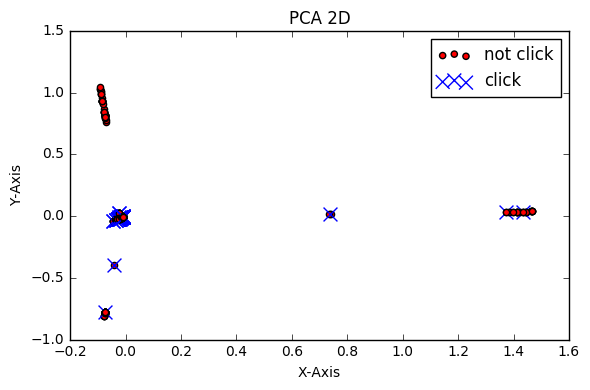

In [50]:
# # 2d
# pca = PCA(n_components=2)
# # xTrainTranspose = xTrain.transpose()
# # pca.fit(xTrainTranspose)
# xTrainPCA = pca.fit_transform(xTrain)
# #PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
# #  svd_solver='auto', tol=0.0, whiten=False)
# #xTrainPCA = pca.components_#.transpose()
# # print(xTrainPCA)


# import numpy as np
# import matplotlib.pyplot as plt


x = xTrainPCA[:,0]
y = xTrainPCA[:,1]
labelCountClick = 0
labelCountnotClick = 0
for i in range(len(x)):
    if i%5 == 0:
        if yTrain[i] == 1 and labelCountnotClick == 0:
            plt.scatter(x[i],y[i],c='b',marker='x', s=100, label='click') #  click
            labelCountnotClick += 1
        elif labelCountClick == 0:
            plt.scatter(x[i],y[i],c='r',marker='o', label='not click') # not click
            labelCountClick += 1
        else:
            if yTrain[i] == 1:
                plt.scatter(x[i],y[i],c='b',marker='x', s=100) # click
            else:
                plt.scatter(x[i],y[i],c='r',marker='o') # not click
            
# plt.set_xlabel('Y-Axis')
# plt.set_ylabel('Z-Axis')
# plt.set_title('PCA')
plt.legend(loc='upper right')
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
# ax.set_zlim3d(-0.02, 0.03)                    
# ax.set_ylim3d(-0.02, 0.03)                    
# ax.set_xlim3d(-0.02, 0.03)
plt.xlabel('X-Axis')
plt.ylabel('Y-Axis')
plt.title('PCA 2D')
plt.show()

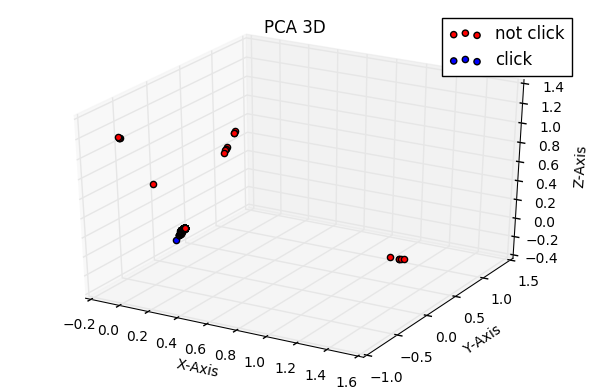

In [21]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')

x = xTrainPCA[:,0]
y = xTrainPCA[:,1]
z = xTrainPCA[:,2]
labelCountClick = 0
labelCountnotClick = 0
for i in range(len(x)):
    if i%30 == 0:
        if yTrain[i] == 1 and labelCountnotClick == 0:
            ax.scatter(x[i],y[i],z[i],c='b',marker='o', label='click') # not click
            labelCountnotClick += 1
        elif labelCountClick == 0:
            ax.scatter(x[i],y[i],z[i],c='r',marker='o', label='not click') # click
            labelCountClick += 1
        else:
            if yTrain[i] == 1:
                ax.scatter(x[i],y[i],z[i],c='b',marker='o') # not click
            else:
                ax.scatter(x[i],y[i],z[i],c='r',marker='o') # click
            
ax.set_xlabel('X-Axis')
ax.set_ylabel('Y-Axis')
ax.set_zlabel('Z-Axis')
ax.set_title('PCA 3D')
plt.legend(loc='upper right')
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
# ax.set_zlim3d(-0.02, 0.03)                    
# ax.set_ylim3d(-0.02, 0.03)                    
# ax.set_xlim3d(-0.02, 0.03)     
plt.show()